<h4>Jesus Esteban Bustamante Apodaca

A2.1 Regresión logística y validación cruzada</h4>
<h5>1. Importa los datos a tu ambiente de trabajo. Especifica qué variable utilizarás como
variable de salida, debe tratarse de una variable binaria. Si no hay ninguna variable
binaria de interés, binariza la variable de salida que utilizaste en el proyecto (si trataste
de predecir el precio de las casas, genera una variable que indique si una casa cuesta
más que cierto monto, o menos).</h5>

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('USA Housing Dataset.csv')
#Para la variabla de salida, seria el precio pero binarizado ya que no hay salidas binarias de interes en el datasheet
medianaPrecio = df['price'].median()
#Se crea una variable "HighPrice" que representa de manera binaria si el precio va mas alla de la mediana o no
df['HighPrice'] = (df['price'] > medianaPrecio).astype(int) 
#Eliminacion de variables cualitativas que no tienen realmente ninguna relevancia
df = df.drop(columns=['date', 'street', 'city', 'statezip', 'country', 'yr_renovated'])
print("Primeras filas: ")
print(df.head())

Primeras filas: 
       price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0   376000.0       3.0       2.00         1340      1384     3.0           0   
1   800000.0       4.0       3.25         3540    159430     2.0           0   
2  2238888.0       5.0       6.50         7270    130017     2.0           0   
3   324000.0       3.0       2.25          998       904     2.0           0   
4   549900.0       5.0       2.75         3060      7015     1.0           0   

   view  condition  sqft_above  sqft_basement  yr_built  HighPrice  
0     0          3        1340              0      2008          0  
1     0          3        3540              0      2007          1  
2     0          3        6420            850      2010          1  
3     0          3         798            200      2007          0  
4     0          5        1600           1460      1979          1  


<h5>2. Separa los datos en entrenamiento y prueba, con una relación de 80/20. Asegúrate de
mantener un balance de clases (es decir, si en la base de datos hay 70% de
observaciones de clase 0 y 30% de observaciones de clase 1, deberá mantenerse una
proporción muy similar tanto en los datos de entrenamiento como en los de prueba), e
imprime en consola las proporciones para los 3 grupos (datos originales, datos de
entrenamiento, datos de prueba).</h5>

In [122]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['price', 'HighPrice'])
y = df['HighPrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Impresion de porcentajes de cada clase de HighPrice en los datos originales, entrenamiento y de prueba
print(f"Datos Originales: ",y.value_counts(normalize=True))
print(f"Datos de entrenamiento: ",y_train.value_counts(normalize=True))
print(f"Datos de prueba: ",y_test.value_counts(normalize=True))

Datos Originales:  HighPrice
0    0.502415
1    0.497585
Name: proportion, dtype: float64
Datos de entrenamiento:  HighPrice
0    0.506944
1    0.493056
Name: proportion, dtype: float64
Datos de prueba:  HighPrice
1    0.5157
0    0.4843
Name: proportion, dtype: float64


<h5>3. Usando los datos de entrenamiento, mide la exactitud de un modelo de regresión logística
usando alguna técnica de validación cruzada. Si tu base de datos era particularmente
compleja, puedes trabajar con 5 características de interés, en vez de con toda la base de
datos, o de tener que realizar un proceso de selección de características</h5>

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

#Escalador de datos por problemas de convergencia
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


modelo = LogisticRegression(solver='saga', penalty=None, class_weight='balanced')
#Validacion cruzada Kfold
selector = SelectKBest(score_func=f_classif, k=5)
X_train_seleccionadas = selector.fit_transform(X_train, y_train)
X_test_seleccionadas = selector.transform(X_test)
variables_seleccionadas = X.columns[selector.get_support()]
print("Características seleccionadas:", variables_seleccionadas.tolist())

#Elegi usar k-fold en vez de LOOCV pues como hay muchos datos en el datasheet que pueda que termine cargando mucho la computadora.
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#Exactitud del modelo de regresion logistica usando CV del kfold
scores = cross_val_score(modelo,X_train, y_train, cv=kfold, scoring='accuracy')
print(f"Exactitud en validación cruzada del modelo:", np.mean(scores))


Características seleccionadas: ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'sqft_above']
Exactitud en validación cruzada del modelo: 0.7650950317380032


<h5>4. Entrena un modelo de regresión logística, similar al del punto anterior, pero utilizando
todo el subconjunto de datos de entrenamiento. Usando dicho modelo, genera un vector
de probabilidades para los datos de prueba. Genera una matriz de confusión y reporta la
exactitud, sensibilidad y especificidad del modelo antes 3 diferentes umbrales (0.5, uno
mayor, y uno menor).</h5>

In [124]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
#Entrenamiento del modelo
modelo.fit(X_train_seleccionadas, y_train)
y_prob = modelo.predict_proba(X_test_seleccionadas)[:, 1]

#umbrales (0.5, 0.6(mayor), 0.4(menor))
umbrales = [0.5, 0.6, 0.4]
for t in umbrales:
    y_pred = (y_prob >= t).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    exactitud = accuracy_score(y_test, y_pred)
    sensibilidad = recall_score(y_test, y_pred)
    especificidad = recall_score(y_test, y_pred, pos_label=0)
    print(f'Umbral: {t} | Exactitud: {exactitud:.4f} | Sensibilidad: {sensibilidad:.4f} | Especificidad: {especificidad:.4f}')
    print(cm)

Umbral: 0.5 | Exactitud: 0.7150 | Sensibilidad: 0.6604 | Especificidad: 0.7731
[[310  91]
 [145 282]]
Umbral: 0.6 | Exactitud: 0.6981 | Sensibilidad: 0.5433 | Especificidad: 0.8628
[[346  55]
 [195 232]]
Umbral: 0.4 | Exactitud: 0.7150 | Sensibilidad: 0.7705 | Especificidad: 0.6559
[[263 138]
 [ 98 329]]


<h5>5. Grafica la curva ROC para las probabilidades calculadas en el punto previo y reporta el
valor de la AUC.</h5>
El AUC es de 0.79 por lo que se podria interpretar que el modelo es aceptable ya que esta mas cerca al 1 por lo que el modelo es capaz de distinguir correctamente entre casas de alto precio o baratas, aunque tambien podria mejorar su rendimiento para obtener un mejor rendimiento.

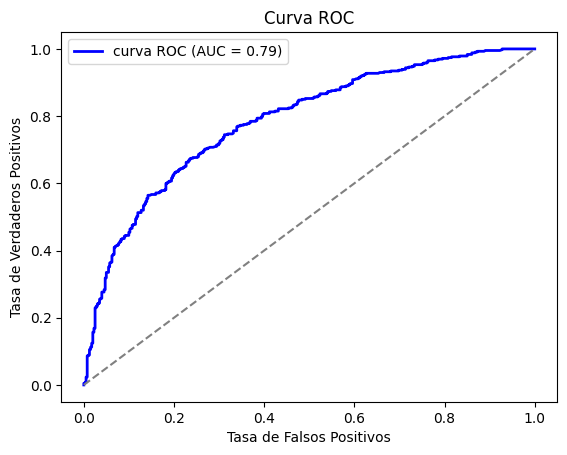

In [125]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()


<h5>6. Interpreta los resultados del modelo, describiendo cómo es que cada variable afecta a la
salida, en términos de los coeficientes generados</h5>
Con las 5 variables seleccionadas por la seleccion de caracteristicas podemos interpretar de los resultados de los coeficientes obtenidos:

"sqrt_living" = Esta variable con un coeficiente de 2.11 representa que tiene un alto impacto en aumentar la posibilidad de que la casa tenga un alto precio.

"floors": Con un coeficiente de 0.2984, da a entender que el numero de pisos de las casas si tiene un impacto en terminar siendo una casa con alto precio pero su impacto no es tan grande como "sqrt_living"

"bathrooms": El numero de baños con un coeficiente de 0.064 tiene un impacto en las casas de alto precio pero es muy bajo.

"bedrooms": El numero de recamaras de acuerdo con los resultados de un coeficiente negativo de -0.23 disminuyen la probabilidad de que la casa sea de alto precio por lo que se podria deber a que posiblemente los cuartos tengan poco espacio u otros factores.

"sqrt_above" = El tamaño del sotano reduce la posibilidad de que la casa sea de alto precio por su coeficiente negativo de -0.49.

In [126]:
coef_df = pd.DataFrame({'Feature': variables_seleccionadas, 'Coefficient': modelo.coef_[0]})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
print('Coeficientes del modelo de regresión logística:')
print(coef_df)

Coeficientes del modelo de regresión logística:
       Feature  Coefficient
2  sqft_living     2.110085
3       floors     0.298425
1    bathrooms     0.064086
0     bedrooms    -0.230858
4   sqft_above    -0.491218
